In [37]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, transpile
from qiskit.algorithms import FasterAmplitudeEstimation, EstimationProblem
from qiskit.providers.aer import AerSimulator
from qiskit.quantum_info import Statevector, Operator
from itertools import product
import numpy as np
import random

# Self learning approximate distributions using a QFT-inspired sampler

In this notebook, the paper [Quantum self-learning Monte Carlo with quantum Fourier transform sampler](https://arxiv.org/abs/2005.14075) is followed to implement an algorithm that learns to approximate a target probability distribution using a quantum sampler inspired by the quantum Fourier transform. The aim of this notebook is to explain how the paper was translated into code, therefore some of the functions are not as efficient as they could be in order to be more readable. A module implementation (which is more efficient) of the same algorithm is available [here](https://github.com/epelaaez/SelfLearningDistributions/tree/main/selflearning).

Given a target hard-to-sample probability distribution $p(x)$, we will create a circuit that represents an easy-to-sample probability distribution $q(x;\theta)$ that approximates the target distribution, where $\theta$ represents the parameters the algorithm is going to learn. 

**Quantum Fourier Transform**

To start things off, we are going to define a function that returns a QFT circuit. We don't use Qiskit's native implementation to get more control over our circuits and facilitate further debugging, but the circuit generated is essentially the same.

In [4]:
def qft(n):
    qc = QuantumCircuit(n)
    for i in range(n - 1, -1, -1):
        qc.h(i)
        for j in range(i - 1, -1, -1):
            x = 2 ** (j - i)
            qc.cp(np.pi * x, i, j)
    for i in range(n // 2):
        qc.swap(i, n - i - 1)
    return qc

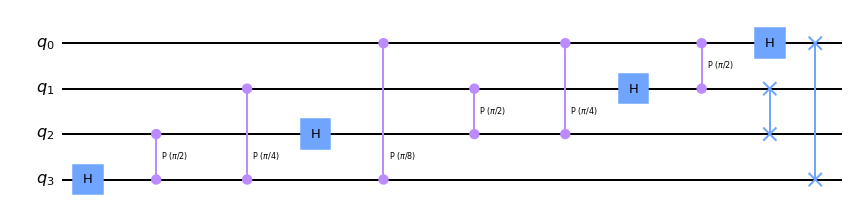

In [5]:
qft(4).draw()

**One-dimensional QFT sampler**

Using our QFT circuit, we can construct the sampler circuit. This is an $n$-qubit circuit consisting of two registers: $|\text{in}\rangle$ of size $m$ and $|0\rangle^{n-m}$. The variational parameters will be firstly encoded into the $|\text{in}\rangle$ register by setting its state into the state

$$ |\psi(\theta)\rangle = \sum_{i=0}^{2^m - 1} \theta_i|i\rangle,$$

where $\theta = [\theta_0, \theta_1, \cdots, \theta_{2^m - 1}]$ with $\theta \in \mathbb{C}$ and is our parameter vector. Since this paramter vector defines a statevector, it needs to be normalized to have unit length. We define the complete initial state as $|\text{in}\rangle = |\psi(\theta)\rangle \otimes |0\rangle^{n-m}$. 

The action of this sampler is to send the state $|\text{in}\rangle$ through a QFT circuit, which results in a state we will call $|\Psi(\theta)\rangle$. Generating the circuit is quite easy and inexpensive. Also, we use Qiskit's `transpile` function to optimize the circuit as much as we can. 

This sampler is the basic building block of our algorithm. Measuring $|\Psi(\theta)\rangle$ in the computational basis is what will determine its probability distribution. Given a random variable $x\in\{0, 1, \dots, 2^n - 1\}$ represented as a binary number, we have

$$ q(x; \theta) = \left|\langle x| \Psi(\theta)\rangle\right|^2 $$

In the case of one qubit, we are going to denote this by $q_{\text{QFT}}(x;\theta)$.

In [6]:
def one_sampler(n, m, params):
    """
    Parameters:
        n: int
            Number of qubits in sampler
        m: int
            Number of qubits in parametrized register
        params: list[complex]
            List of of size 2**m of complex parameters
    """
    p  = QuantumRegister(m, "in")
    g  = QuantumRegister(n - m, "g")
    qc = QuantumCircuit(p, g)
    
    # Encode parameters into first m qubits
    qc.initialize(params, p)
    
    # Perform QFT
    qc.compose(qft(n), inplace=True)
    
    return transpile(qc, basis_gates=["cx", "u"], optimization_level=3)

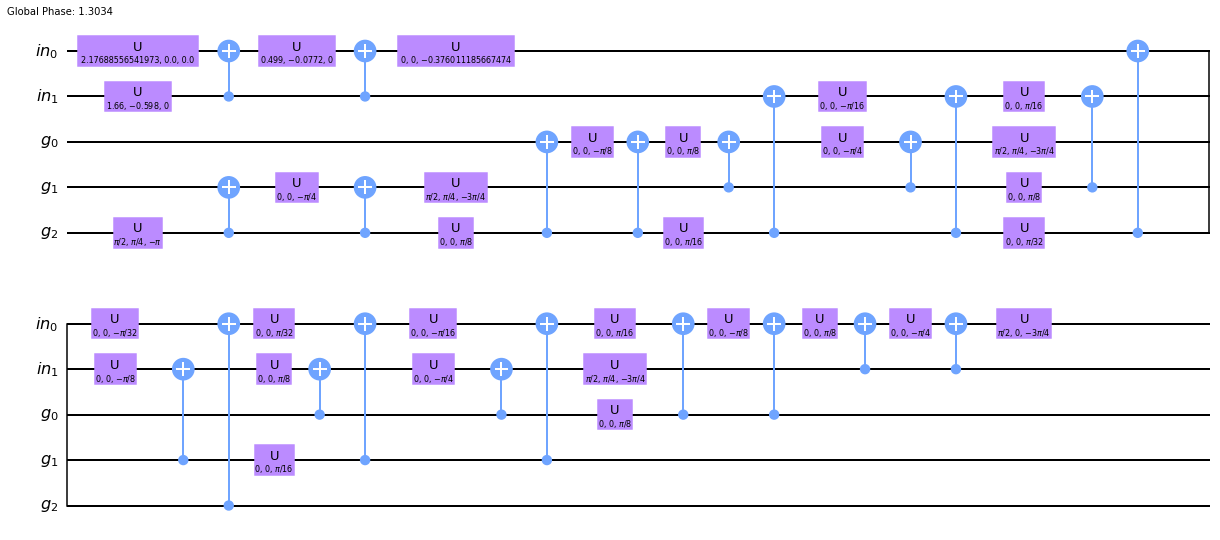

In [7]:
params  = np.random.random(2 ** 2) + np.random.random(2 ** 2) * 1j
params  = params / np.linalg.norm(params)
sampler = one_sampler(5, 2, params)
sampler.draw()

**Probability of random variable from circuit**

Since we have that $q(x; \theta) = \left|\langle x| \Psi(\theta)\rangle\right|^2$, knowing the amplitude of a specific ket $|x\rangle$ in $|\Psi(\theta)\rangle$ is going to be an important task. To do this, we are going to use the quantum ampitude estimation algorithm, or more specifically, the [`FasterAmplitudeEstimation`](https://qiskit.org/documentation/stubs/qiskit.algorithms.FasterAmplitudeEstimation.html) class that Qiskit has. A detailed description of how this variant works can be found in [*Faster Amplitude Estimation*](https://arxiv.org/abs/2003.02417).

A more efficient algorithm to classicaly simulate the type of circuits used in this algorithm is given in Appendix A of the original paper. This relies on measuring qubits as soon as they are not involved in further gates and therefore all the controlled-rotation gates are transformed into classicaly-controlled gates, which makes it possible to simulate the circuit via repeated matrix multiplication, leading to a cost of $O(2^m+n)$. For more details, read the mentioned appendix. 

In [13]:
def prob_from_circ(qc, r, backend=AerSimulator(method="statevector"), shots=10000, delta=0.01, maxiter=3):
    """
    Calculate |<r|psi>|**2 where r is the sample and psi the final state of the circuit
    
    Parameters:
        qc: QuantumCircuit
            Circuit that prepares final state
        r: int
            Random variable to sample
        backend: AerBackend
            Backend to run circuit on
        shots: int
            Number of shots per circuit
        delta: float
            Accuracy for FAE algorithm
        maxiter: int
            Iterations for FAE algorithm
    """
    b    = format(r, 'b').zfill(qc.num_qubits)[::-1]
    qc_i = qc.copy()
    for i in range(qc.num_qubits):
        if b[i] == "0":
            qc_i.x(i)
            
    problem = EstimationProblem(
        state_preparation = qc_i,
        objective_qubits  = [i for i in range(qc.num_qubits)],
    )

    fae = FasterAmplitudeEstimation(
        delta            = delta,
        maxiter          = maxiter,
        quantum_instance = backend,
    )
    result = fae.estimate(problem)
    
    return result.estimation

In [14]:
params  = np.random.random(2 ** 2) + np.random.random(2 ** 2) * 1j
params  = params / np.linalg.norm(params)
sampler = one_sampler(4, 2, params)

vec = Statevector(sampler).data
for i in range(len(vec)):
    vec[i] = np.real(vec[i] * np.conj(vec[i]))

total = 0
for var in range(2**4):
    prob   = prob_from_circ(sampler, var)
    total += prob
    print(f"Experimental p({var}) = {prob}. Theoretical: {np.round(vec[var], 4)}.")
    
print(f"Total probability: {total}")

Experimental p(0) = 0.20424672755567122. Theoretical: (0.2042+0j).
Experimental p(1) = 0.013069076225010079. Theoretical: (0.0131+0j).
Experimental p(2) = 0.023049207652459096. Theoretical: (0.023+0j).
Experimental p(3) = 0.009634988566860512. Theoretical: (0.0096+0j).
Experimental p(4) = 0.038401870238618414. Theoretical: (0.0384+0j).
Experimental p(5) = 0.017912303732975584. Theoretical: (0.0179+0j).
Experimental p(6) = 0.03441654469949107. Theoretical: (0.0344+0j).
Experimental p(7) = 0.15926928132891582. Theoretical: (0.1593+0j).
Experimental p(8) = 0.12128621137677967. Theoretical: (0.1213+0j).
Experimental p(9) = 0.02042270613114106. Theoretical: (0.0204+0j).
Experimental p(10) = 0.04083911273734841. Theoretical: (0.0408+0j).
Experimental p(11) = 0.06745196975473086. Theoretical: (0.0675+0j).
Experimental p(12) = 0.007677989250900907. Theoretical: (0.0077+0j).
Experimental p(13) = 0.0034766665290071335. Theoretical: (0.0035+0j).
Experimental p(14) = 0.01715155954673264. Theoretic

**Multistage QFT sampler**

When working with probability distributions that depend on multi-dimensional random variables, we are going to use what we call a multistage sampler. Basically, this is a collection of $D$ circuits (where $D$ is the dimension of the random variables), and therefore we are also going to have $D$ complex parameter vectors. In the case where the random variables are independent from each other, we have the following formula for the probability distribution:

$$
q(x;\theta) = \prod_{k=1}^D q_{\text{QFT}}(x_k, \theta_k)
$$

So, $\theta$ turns into $\theta=[\theta_1^T,\dots,\theta_D^T]^T$ and $x$ into $x=[x_1, \dots, x_D]^T$. In order to introduce dependance between random variables, we are going to make the parameter vector $\theta_{k}$ depend on the random variables $x_1, \dots, x_{k-1}$. Therefore, each $\theta_k$ is replaced with a function $f_k(x_1, \dots, x_{k-1};\theta_k)$, where we still optimize $\theta_k$ through the algorithm. In this case, the formula for the probability distribution given by the quantum sampler is:

$$
q(x;\theta) = \prod_{k=1}^D q_{\text{QFT}}(x_k, f_k(x_1, \dots, x_{k-1}; \theta_k))
$$

The functions $f_k$ can take on many forms. The most simple one can is what the authors of the paper call the identity model, which simply normalizes the paramters by setting:

$$
f_k(x_1, \dots, x_{k-1} ;\theta_k) = \text{Norm}(\theta_k) =  \frac{\theta_k}{\|\theta_k\|}
$$

In this case, the distribution is again reduced to one with independent random variables, since $f_k$ does not really depend on previous variables. On the other hand, the linear basis linear regression model includes dependency between variables:

$$
f_k(x_1, \dots, x_{k-1}; \theta_k) = \text{Norm}\left(w_1^{(k)}x_1 + \dots + w_{k-1}^{(k)}x_{k-1} + b^{(k)}\right)
$$

In this case, each $\theta_k$ turns into a collection of $2^m$ complex paramters $\theta_k = \{w_1^{(k)}, w_2^{(k)}, \dots w_{k-1}^{(k)}, b^{(k)}\}$. Another example of function that introduces a dependency between variables is a nonlinear basis linear regression model give by:

$$
f_k(x_1, \dots, x_{k-1}; \theta_k) = \text{Norm}\left( \sum_{j=1}^J w_j^{(k)}\phi_j^{(k)}(x_1, \dots, x_{k-1}) + b^{(k)} \right)
$$

Here, each $\phi_j^{(k)}$ is a fixed nonlinear basis function and $\theta_k$ is similar to the linear basis case. More details on what form can $\phi_j^{(k)}$ take are provided in section III.B of the original paper. In that same section, a neural-network model is introduced, however, that approach is out of scope of this brief project. 

In [20]:
def multi_sampler(D, n, m, params):
    """
    Parameters:
        D: int
            Dimension of independent target distribution
        n: int
            Number of qubits in each one dimensional sampler
        m: int
            Number of qubits in parametrized register
        params: list[list[complex]]
            List of size D of lists of complex parameters of size 2 ** m
            This need to be already processed with function
    """
    circs = []
    for k in range(D):
        circs.append(one_sampler(n, m, params[k]))
    return circs

Sampler 0:


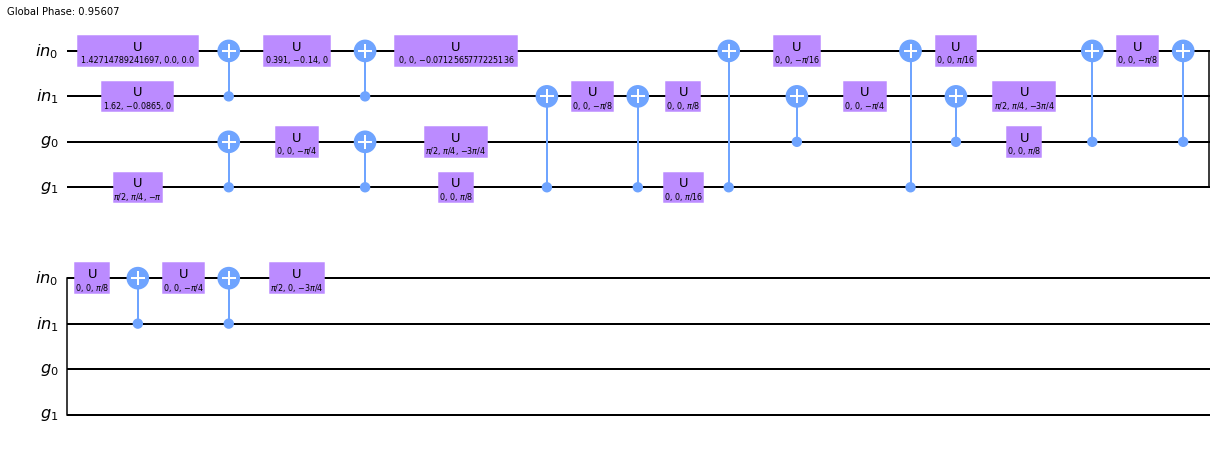

Sampler 1:


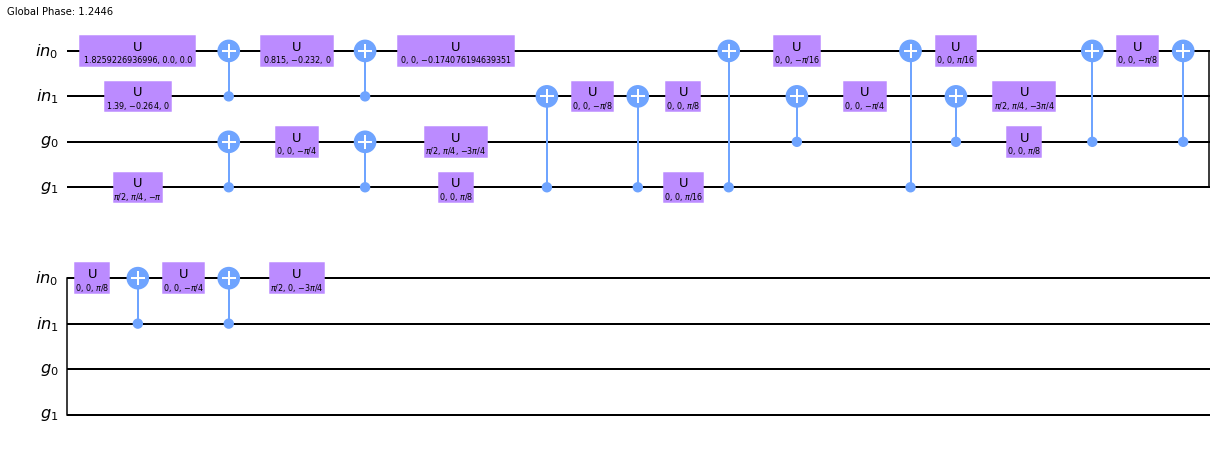

In [10]:
D = 2
n = 4
m = 2

params = []
for _ in range(D):
    params.append(np.random.random(2 ** m) + np.random.random(2 ** m) * 1j)

# we use the normalizer functions that do not create dependency between random variables
funcs = [
    lambda var, theta: theta / (np.sqrt(np.dot(theta, theta.conj()))),
    lambda var, theta: theta / (np.sqrt(np.dot(theta, theta.conj())))
]

# we need to define the random variable to sample since the paramters now depend on it
# (not in this case since we do not create dependency, but we will need to in the other cases)
r          = np.random.randint(2**m, size=D) 
new_params = []
for k in range(len(params)):
    new_params.append(funcs[k](r[0:k], params[k]))
circs = multi_sampler(D, n, m, new_params)

for i in range(D):
    print(f"Sampler {i}:")
    display(circs[i].draw())

For convenience, we can take the code that computes the processed parameters and turn it into a function that will come in handy later on.

In [15]:
def process_params(r, funcs, params):
    """
    Parameters:
        r: list[int]
            Multi-dimensional random variable
        funcs: list[lambda or func]
            List of processing functions
        params: list[list[complex]]
            List of lists of complex parameters
    """
    new_params = []
    for k in range(len(params)):
        new_params.append(funcs[k](r[0:k], params[k]))
    return new_params

**Probability from multistage sampler**

Just as in the one-dimensional case, we need to determine the amplitude of certain computational basis states for each circuit in order to get the value of a random variable in our probability distribution. This is easily done following the product formula introduced in the section above. 

$$ q(x;\theta) = \prod_{k=1}^D q_{\text{QFT}}(x_k, f_k(x_1, \dots, x_{k-1}; \theta_k)) $$

As you can see, this is simply the product of amplitudes of $D$ one-dimensional samplers. 

In [17]:
def prob_from_multi_circ(q, r, backend=AerSimulator(method="statevector"), shots=10000):
    """
    Parameters:
        q: list[QuantumCircuits]
            List of circuits that approximate distribution
        r: list[int]
            Multi-dimensional random variable
        backend: AerBackend
            Backend to run circuits on
        shots: int
            Number of shots per circuit
    """
    q_x = 1
    for i in range(len(r)):
        q_x *= prob_from_circ(q[i], r[i], backend=backend, shots=shots)
    return q_x

In [21]:
D = 2
n = 3
m = 1

params = []
for _ in range(D):
    params.append(np.random.random(2 ** m) + np.random.random(2 ** m) * 1j)

funcs = [
    lambda var, theta: theta / (np.sqrt(np.dot(theta, theta.conj()))),
    lambda var, theta: theta / (np.sqrt(np.dot(theta, theta.conj())))
]

r   = list(product([i for i in range(2**n)], repeat=D))
r   = [list(r_i) for r_i in r]
tot = 0

for r_i in r:
    circs = multi_sampler(D, n, m, process_params(r_i, funcs, params))
    tot  += prob_from_multi_circ(circs, r_i)
    
print(f"Sum of all probabilities: {tot}")

Sum of all probabilities: 1.0


**Cross entropy**

Given our target distribution $p(x)$ and our proposal distribution $q(x; \theta)$, we are going to use the cross entropy as a measure to quantify the similarity between them. The formula for cross entropy is:

$$ H(p, q) = - \sum_x p(x) \log q(x; \theta)$$

This measure will also be used as our loss function $L(\theta)$. 

In [23]:
def cross_entropy(p, q, r, mode, backend=AerSimulator(method="statevector"), shots=10000):
    """
    Parameters:
        p: lambda or func
            Function to compute p(x)
        q: QuantumCircuit or list[int, int, int, list[list[complex]], list[func]
            If one-dimensional, it should be a single circuit
            If multisampler, it should be a list of arguments with
            D, n, m, params and funcs
        r: list[int] or list[list[int]]
            If one-dimensional, it should be a list of integers
            If multisampler, if should be a list of lists of integers,
            each with same length as number of samplers
        mode: str
            "one" for one qubit sampler and "multi" for multistage
        backend: AerBackend
            Backend to run circuits on
        shots: int
            Number of shots for each sampler
    """
    entropy = 0
    
    all_q_x = []
    for var in r:
        if mode == "one":
            all_q_x.append(prob_from_circ(q, var, backend=backend, shots=shots))
        else:
            all_q_x.append(prob_from_multi_circ(multi_sampler(q[0], q[1], q[2], process_params(var, q[4], q[3])), 
                                                var, backend=backend, shots=shots))
            
    for i in range(len(r)):
        if np.isclose(all_q_x[i], 0):
            continue
        entropy += p(r[i]) * np.log2(all_q_x[i])
        
    return -entropy

Sampler 0:


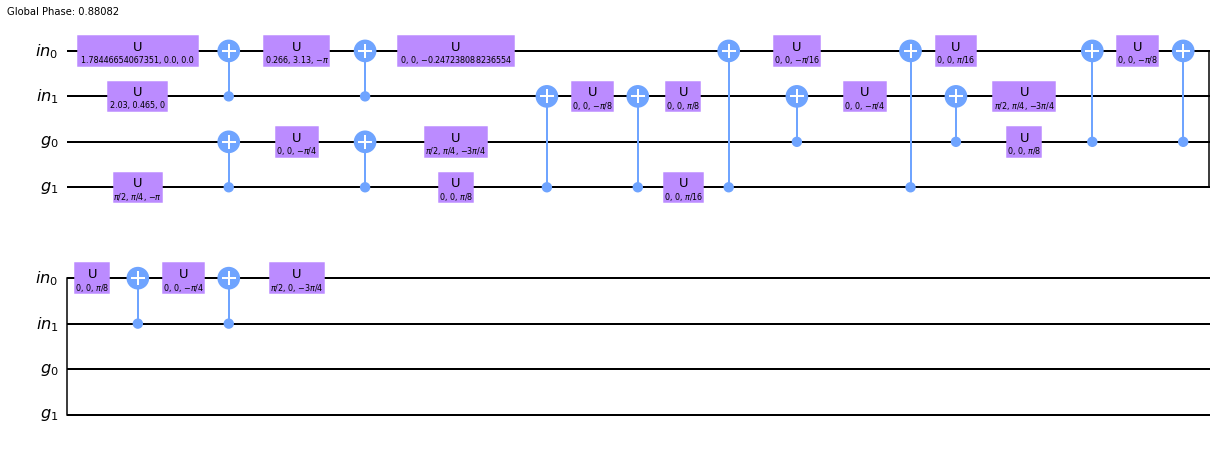

Sampler 1:


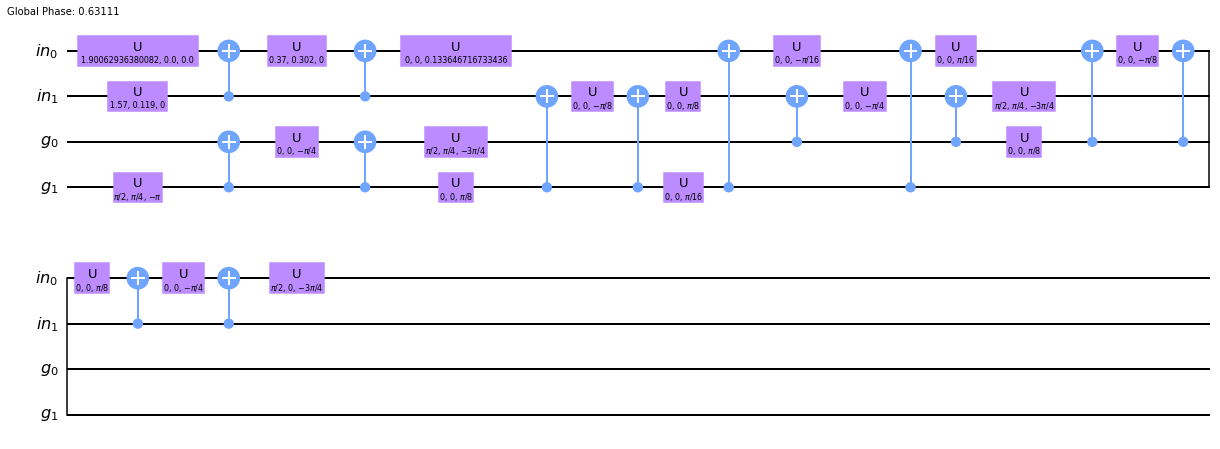

Sampler 2:


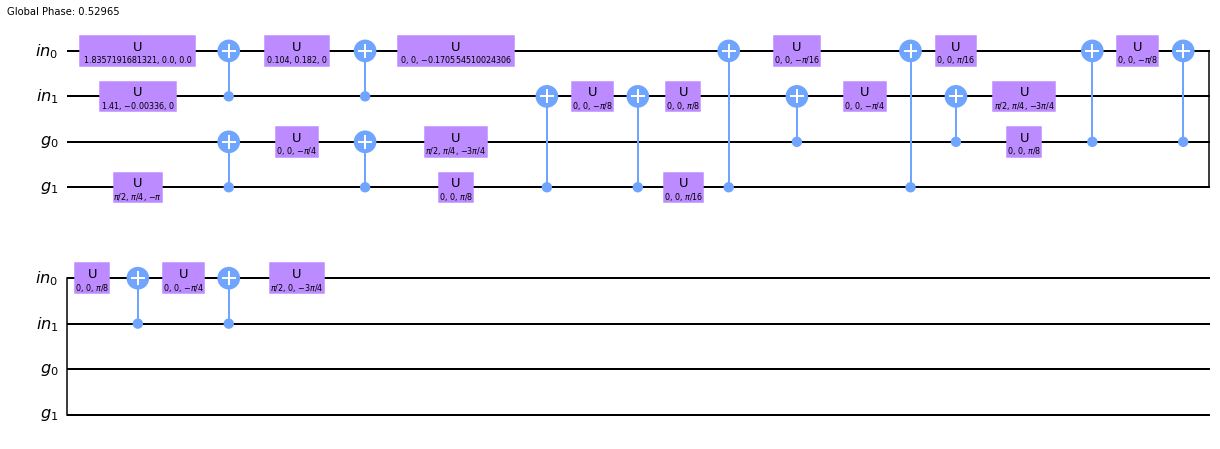

In [24]:
D = 3
n = 4
m = 2

# For this example we experiment with a linear basis regression model
# in the second and third samplers, the first one remains the identity
params = []

# Params for first sampler
params.append(np.random.random(2 ** m) + np.random.random(2 ** m) * 1j)

# Params for second and third sampler
# Needs two (three) 2**m dimensional vectors
params.append([np.random.random(2 ** m) + np.random.random(2 ** m) * 1j for _ in range(2)])
params.append([np.random.random(2 ** m) + np.random.random(2 ** m) * 1j for _ in range(3)])

# Define LBRM function for second and third samplers
def lbrm(var, theta):
    vec = np.array(theta[-1])
    for i in range(len(var)):
        vec += var[i] * theta[i]
    return vec / np.sqrt(np.dot(vec, vec.conj()))

funcs = [
    lambda var, theta: theta / (np.sqrt(np.dot(theta, theta.conj()))),
    lbrm,
    lbrm,
]

r     = np.random.randint(2**m, size=D)
circs = multi_sampler(D, n, m, process_params(r, funcs, params))

for i in range(D):
    print(f"Sampler {i}:")
    display(circs[i].draw())

In [25]:
# We will make the target distribution be an equal distribution
# There are 3 random variables, each with 2**4 possible values,
# therefore there are 4096 total random variables
def target(x):
    return 1 / 4096

# We will only sample 64 random variables for efficiency
r_var = []
for i in range(4):
    for j in range(4):
        for k in range(4):
            r_var.append([i, j, k])

# Note that the result is not favorable since we don't optimize anything yet
entropy = cross_entropy(target, [D, n, m, params, funcs], r_var, mode="multi")
print(f"Calculated cross entropy: {entropy}")

Calculated cross entropy: 0.2814763649287457


**Gradient of $L(\theta)$**

Now that we have $L(\theta) = H(p, q)$, we can compute the gradient of this function so we can update our parameters and optimize them. We are going to focus on the one-dimensional case first, and this gradient turns out to be:

$$
\frac{\partial L(\theta)}{\partial \theta} \approx - \frac{1}{B} \sum_{i=1}^B \frac{p(r_i)}{q_{\text{QFT}}(r_i; \theta)^2}\frac{\partial q_{\text{QFT}}(r_i; \theta)}{\partial \theta}
$$

For some random variables $r_1, \dots, r_B$. The partial derivative inside this formula may seem a bit criptic, but this is given by the following formula:

$$
\frac{\partial q_{\text{QFT}}(x;\theta)}{\partial \theta} = (u_x^{\dagger}\theta^*)u_x
$$

Where $u_x$ is the vector composed of the first $2^m$ elements of the $x$-th row of the operator corresponding to the QFT circuit (without initialization). 

We are going to be updating our parameters with the conjugate of the gradient, so we end up with the following formula for the gradient of the one-dimensional loss function: 

$$
\left(\frac{\partial L(\theta)}{\partial \theta}\right)^* \approx - \frac{1}{B} \sum_{i=1}^B \frac{p(r_i)}{q_{\text{QFT}}(r_i; \theta)^2} (u_{r_i}^T\theta)u_{r_i}^*
$$

For more details on this specific derivation and how to compute everything here, refer to sections II.B and III.A of the reference paper.

First, we are going to define some functions to compute the second part of the formula.

In [30]:
def u_qft_x_j(x, j, N):
    """
    Return the j element of the x row of the unitary of QFT of size N
    """
    return (1 / np.sqrt(2**N)) * np.exp(1j * 2 * np.pi * x * j / (2 ** N))

def qft_derivative(x, theta, N):
    """
    Parameters:
        x: int
            Random variable
        theta: list[complex]
            List of complex parameters
        N: int
            Number of qubits in sampler
    """
    m   = len(theta)
    u_x = np.array([u_qft_x_j(x, j, N) for j in range(m)])
    dot = np.dot(u_x, theta)
    return dot * u_x.conj()

In [29]:
x    = 3
N    = 4
m    = 2 ** 3
u_x1 = np.array([u_qft_x_j(x, j, N) for j in range(m)])
u_x2 = Operator(qft(N)).data[x][0:m]

print(u_x1)
print(u_x2)
print(np.allclose(u_x1, u_x2))

[ 2.50000000e-01+0.j          9.56708581e-02+0.23096988j
 -1.76776695e-01+0.1767767j  -2.30969883e-01-0.09567086j
 -4.59242550e-17-0.25j        2.30969883e-01-0.09567086j
  1.76776695e-01+0.1767767j  -9.56708581e-02+0.23096988j]
[ 2.50000000e-01+0.j          9.56708581e-02+0.23096988j
 -1.76776695e-01+0.1767767j  -2.30969883e-01-0.09567086j
 -1.53080850e-17-0.25j        2.30969883e-01-0.09567086j
  1.76776695e-01+0.1767767j  -9.56708581e-02+0.23096988j]
True


In [31]:
params  = np.random.random(2 ** 2) + np.random.random(2 ** 2) * 1j
params  = params / np.linalg.norm(params)
qft_derivative(3, params, 4)

array([-0.03379506+0.00179647j, -0.01127309+0.03191005j,
        0.02516701+0.02262642j,  0.03053509-0.01459253j])

And now we can compute the whole gradient.

In [34]:
def one_loss_gradient(p, q, r, params, backend=AerSimulator(method="statevector"), shots=10000):
    """
    Parameters:
        p: lambda or func
            Function to compute p(x)
        q: QuantumCircuit
            Circuit approximating target distribution
        r: list[int]
            List of random variables to calculate gradient with
        params: list[complex]
            List of complex parameters
        backend: AerBackend
            Backend to run circuits on
        shots: int
            Number of shots for each sampler
    """
    B    = len(r)
    N    = q.num_qubits
    grad = np.zeros(len(params), dtype="complex")
    
    for i in range(B):
        num = p(r[i])
        den = prob_from_circ(q, r[i], backend=backend, shots=shots)**2
        if den == 0:
            frac = num / 1e-18
        elif den == 0 and num == 0:
            frac = 0
        else:
            frac = num / den
        grad += frac * qft_derivative(r[i], params, N)
        
    return -(1 / B) * grad 

In [35]:
params  = np.random.random(2 ** 2) + np.random.random(2 ** 2) * 1j
params  = params / np.linalg.norm(params)
sampler = one_sampler(5, 2, params)

def target(x):
    return 1 / (2 ** 5)

one_loss_gradient(target, sampler, [i for i in range(2**5)], params)

array([-165.28770502 -69.36974377j, -215.34753147  +6.75855232j,
          0.97912899-141.46400448j,  -84.0144779 -228.67626096j])

Given the gradient of the loss function, we can compute the change to our previous paramters. This paper follows a momentum gradient descent, which is determined by the following two formulas:

$$
\theta^\prime = \theta - \alpha m^\prime, \hspace{4mm} m^\prime = \mu m + (1-\mu)\left( \frac{\partial L(\theta)}{\partial \theta} \right)^*
$$

Where $\alpha$ and $\mu$ are the learning coefficients.

In [36]:
def one_gradient_change(mu, grad, prev_grad):
    m = (mu * prev_grad) + ((1 - mu) * grad)
    return m

With this in place, we can expand to the multistage case. The complete derivation of the gradient in this case is found in section III.B, which ends up giving us the following formula:

$$
\left(\frac{\partial L(\theta)}{\partial \theta}\right)^* \approx -\frac{1}{B} \sum_{i=1}^B \frac{p(r_i)}{q(r_i; \theta)}\frac{(u_{r_{ik}} f_k)u_{r_{ik}}^*}{q_{\text{QFT}}(r_{ik}; f_k)}\frac{\partial f_k}{\partial \theta_k}
$$

Where $r_1, \dots, r_B$ are $D$-dimensional random variables and $r_{ik}$ represents the $k$-th element of $r_i$. Remember that $q(r_i;\theta)$ represents the probability of the $D$-dimensional random variable and $q_{\text{QFT}}(r_{ik}; f_k)$ the probability of a one-dimensional variable. Also, $f_k$ is shorthand for $f_k(x_1, \dots, x_{k-1}; \theta_k)$.

The difficult part here is finding the derivative of the function $f_k$. To do this, we can first find the derivative of the function $\text{Norm(\theta)}$ and apply the chain rule when neccesary (i.e., second and last cases introduced earlier on).

To find this derivative, we analize the behavior for each element of $\theta$. Thus, we have:

$$
\begin{align}
\frac{\partial}{\partial \theta_i}\frac{\theta}{\|\theta\|} &= \frac{\theta_{\theta_i}\|\theta\| - \theta \|\theta\|_{\theta_i}}{\|\theta\|^2} \\ &= \frac{\|\theta\||i\rangle - \frac{\theta_i}{\|\theta\|}\theta}{\|\theta\|^2} \\ &= \frac{|i\rangle}{\|\theta\|} - \frac{\theta_i}{\|\theta\|^3}\theta
\end{align}
$$

Where $|i\rangle$ is a vector with all zeros except for a $1$ in the $i$-th element. As you can see, this gives us a column vector, therefore, the derivative with respect to the whole vector $\theta$ is a matrix. Which makes sense since we need to multiply it by a vector in the gradient formula. Also [here](https://math.stackexchange.com/a/818467) is a nice derivation of the derivative of $\|\theta\|$ in case you need it.

In [68]:
def multi_loss_gradient(p, q, r, params, funcs, derivs, backend=AerSimulator(method="statevector"), shots=10000):
    """
    Parameters:
        p: lambda or func
            Function to compute p(x)
        q: list[int, int, int]
            Arguments to create multisampler, it should
            be a list of arguments with D, n, and m
        r: list[list[int]]
            List of random variables to calculate gradient with
        params: list[list[complex]]
            List of complex parameters
        funcs: list[lambda or func]
            List of functions
        derivs: list[lambda or func]
            List of functions of derivatives of funcs
        backend: AerBackend
            Backend to run circuits on
        shots: int
            Number of shots for each sampler
    """
    D    = q[0]
    n    = q[1]
    m    = q[2]
    B    = len(r)
    grad = []
    
    # TODO: derivative of function
    for k in range(len(params)):
        if len(r[0][0:k]) > 0:
            grad_k = [np.zeros(2**m,dtype="complex") for _ in range(k+1)]
        else:
            grad_k = np.zeros(2**m, dtype="complex")
        for i in range(B):
            new_params = np.array(process_params(r[i], funcs, params))
            mat        = derivs[k](r[i][0:k], new_params[k])
            circs      = multi_sampler(D, n, m, new_params)
            frac_1     = qft_derivative(r[i][k], new_params[k], n) / prob_from_circ(circs[k], r[i][k], backend=backend, shots=shots)
            frac_2     = p(r[i]) / prob_from_multi_circ(circs, r[i], backend=backend, shots=shots)
            if len(r[i][0:k]) > 0:
                for j in range(len(grad_k)):
                    grad_k[j] += np.dot(frac_1 * frac_2, mat[j])
            else:
                grad_k += np.dot(frac_1 * frac_2, mat)
        grad.append(np.multiply(-1/B, grad_k))
        
    return grad

In [69]:
D = 3
n = 4
m = 2

params = []
params.append(np.random.random(2 ** m) + np.random.random(2 ** m) * 1j)
params.append([np.random.random(2 ** m) + np.random.random(2 ** m) * 1j for _ in range(2)])
params.append([np.random.random(2 ** m) + np.random.random(2 ** m) * 1j for _ in range(3)])

funcs = [
    lambda var, theta: theta / (np.sqrt(np.dot(theta, theta.conj()))),
    lbrm,
    lbrm,
]

def id_deriv(var, theta):
    mat = []
    n   = np.linalg.norm(theta)
    for i in range(len(theta)):
        ones    = np.zeros(len(theta))
        ones[i] = 1
        mat.append((ones / n) - ((theta[i] / (n ** 3)) * theta))
    return np.array(mat)

def lbrm_deriv(var, theta):
    norm_deriv = id_deriv(var, theta)
    mat        = []
    for i in range(len(var)):
        mat.append(np.multiply(norm_deriv, var[i]))
    mat.append(norm_deriv)
    return np.array(mat)
    
derivs = [
    id_deriv,
    lbrm_deriv,
    lbrm_deriv,
]

def target(x):
    return 1 / (4096)

var = []
for i in range(2):
    for j in range(2):
        for k in range(2):
            var.append([i, j, k])

gradient = multi_loss_gradient(target, [D, n, m], var, params, funcs, derivs)
for i, grad in enumerate(gradient):
    print(f"Gradient {i}: {grad}")

Gradient 0: [-63399.3827754 -16171.60562785j -88314.72687384+15802.85207516j
 -64784.13885629+28522.94325027j -87829.64946479+53578.75500305j]
Gradient 1: [[-1416.24607194-1514.98333069j -4557.32899117 +226.64616508j
  -3781.42573319+1373.97210375j -6938.43639938+1566.4918933j ]
 [-1417.13286142-1517.15970344j -4560.38234166 +225.43193742j
  -3783.42754443+1373.65667084j -6942.62286744+1566.11966844j]]
Gradient 2: [[ -54703.46316955-34010.67335506j -136121.06666414-43580.2502352j
  -204285.21332949+15262.24891529j -209719.71251457+67161.08504388j]
 [ -54580.7079073 -33738.60263917j -135557.45440592-43205.75639967j
  -203498.30037562+15596.95840895j -208825.97751563+67184.87211036j]
 [ -54723.37070209-34022.50410493j -136155.41345972-43581.94769224j
  -204346.70496248+15282.66223138j -209775.30930142+67183.63421905j]]


In [70]:
params[0] += gradient[0]
params[1] += gradient[1]
params[2] += gradient[2]
print("Success, gradient has same shape as parameters.")

Success, gradient has same shape as parameters.


As you can see, we got everything we need now to compute gradients for both the one- and multi-dimensional samplers.

**Accepting samples**

Up until now we omitted a small detail about generating samples of random variables using our approximate distribution. This is that, following the classical Metropolis-Hastings algorithm, we accept a variable $\tilde r$ with probability:

$$
A(\tilde r, r) = \min \left\{ 1, \frac{p(\tilde r) q(r)}{p(r) q(\tilde r)} \right\}
$$

Given that the variable $r$ was accepted before.

In [72]:
def accept(p, q, r, r_hat, backend=AerSimulator(method="statevector"), shots=10000):
    """
    Parameters:
        p: lambda or func
            Function to compute p(x)
        q: QuantumCircuit or list[int, int, int, list[], list[]]
            Circuit or arguments to create circuit that
            approximate distribution. List should have
            D, n, m, funcs, and params. 
        r: int or list[int]
            Last accepted sample
        r_hat: int or list[int]
            Sample to accept or reject
        backend: AerBackend
            Backend to run circuits on
        shots: int
            Number of shots for each sampler
    """
    if isinstance(r, int):
        num = p(r_hat) * prob_from_circ(q, r, backend=backend, shots=shots)
        den = p(r) * prob_from_circ(q, r_hat, backend=backend, shots=shots)
    else:
        D      = q[0]
        n      = q[1]
        m      = q[2]
        funcs  = q[3]
        params = q[4]
        
        q_r  = multi_sampler(D, n, m, process_params(r, funcs, params))
        q_rh = multi_sampler(D, n, m, process_params(r_hat, funcs, params))
        
        num = p(r_hat) * prob_from_multi_circ(q_r, r, backend=backend, shots=shots)
        den = p(r) * prob_from_multi_circ(q_rh, r_hat, backend=backend, shots=shots)
    if den != 0:
        prob = num / den
    else:
        prob = float("inf")
    return min([1, prob])

In [73]:
D = 2
n = 4
m = 2

params = []
for _ in range(D):
    params.append(np.random.random(2 ** m) + np.random.random(2 ** m) * 1j)

funcs = [
    lambda var, theta: theta / (np.sqrt(np.dot(theta, theta.conj()))),
    lambda var, theta: theta / (np.sqrt(np.dot(theta, theta.conj())))
]

def target(x):
    return 1 / 256

r        = np.random.randint(2**n, size=D) # set some starting variable
accepted = [r]
counter  = 0
for i in range(10): # test 10 random variables
    while True:
        r_hat = np.random.randint(2**n, size=D)
        counter += 1
        if np.random.rand() < accept(target, [D, n, m, funcs, params], r, r_hat):
            accepted.append(r_hat)
            r = r_hat
            break
print(f"Total tested: {counter}. Accepted: {len(accepted)-1}.")
print(accepted)

Total tested: 60. Accepted: 10.
[array([0, 3]), array([ 3, 14]), array([12, 10]), array([3, 3]), array([13, 14]), array([11, 10]), array([13,  5]), array([4, 6]), array([11, 10]), array([11, 10]), array([3, 3])]


**Approximating a one-dimensional distribution**

Now that we have everything we need in place, we can start testing out our algorithm. First, we will work with the one-dimensional sampler to approximate probability distributions that depend on one-dimensional random variables.

In [74]:
import scipy.stats as stats
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [75]:
plt.rcParams["figure.figsize"] = (9,6)

We are going to start trying to approximate a simple normal distribution. We are going to use 5 qubits, so the random variable will be in the range $[0, 32)$. 

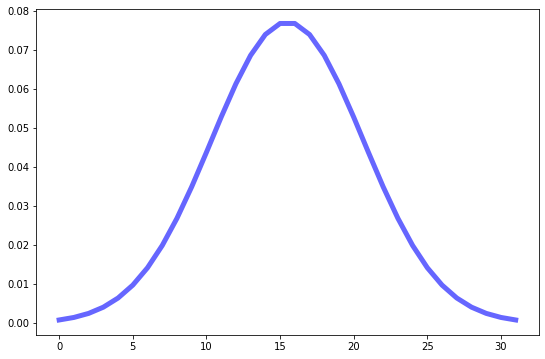

In [76]:
n    = 5
std  = (2**n-1) / 6
mean = (2**n-1) / 2

def norm(x):
    frac = 1 / (std * np.sqrt(2 * np.pi))
    exp  = (- 1 / 2) * (((x - mean) / std)**2)
    return frac * np.exp(exp)

x = [i for i in range(2**n)]
y = [norm(i) for i in x]
plt.plot(x, y, 'b-', lw=5, alpha=0.6, label='normal pdf')

We are going to use $2$ qubits to encode the complex parameters. This time, we will be smarter when choosing our starting parameters. We will choose the parameters such that they give an equal superposition of all states in the final state. As you can see in the cell below, this is done by setting the initial parameters to $\left[1 + 1i, 0, \cdots, 0\right]$ (normalized). Then, we will optimize these parameters to accurately approximate the normal distribution. So, we initialize the sampler will look as follows.

In [77]:
n = 5
m = 2

params    = np.zeros(2**m, dtype="complex")
params[0] = 1 + 1j
params    = params / np.linalg.norm(params)
sampler   = one_sampler(n, m, params)

Statevector(sampler)

Statevector([0.125+0.125j, 0.125+0.125j, 0.125+0.125j, 0.125+0.125j,
             0.125+0.125j, 0.125+0.125j, 0.125+0.125j, 0.125+0.125j,
             0.125+0.125j, 0.125+0.125j, 0.125+0.125j, 0.125+0.125j,
             0.125+0.125j, 0.125+0.125j, 0.125+0.125j, 0.125+0.125j,
             0.125+0.125j, 0.125+0.125j, 0.125+0.125j, 0.125+0.125j,
             0.125+0.125j, 0.125+0.125j, 0.125+0.125j, 0.125+0.125j,
             0.125+0.125j, 0.125+0.125j, 0.125+0.125j, 0.125+0.125j,
             0.125+0.125j, 0.125+0.125j, 0.125+0.125j, 0.125+0.125j],
            dims=(2, 2, 2, 2, 2))


Here we have some parameters that give an equal superposition after going through the QFT. In other words, we have a sampler that represents a uniform distribution in the range $[0, 32)$. Therefore, it is worth exploring the cross entropy, acceptance ratio and change in the parameters after one learning step of this sampler to make sure all the functions we have defined up to this point are working correctly.

Cross entropy of sampler against target: 5.0.
Acceptance ratio of 1.0.
Euclidean norm between initial and udpated params: 1.5700950296856504e-16.


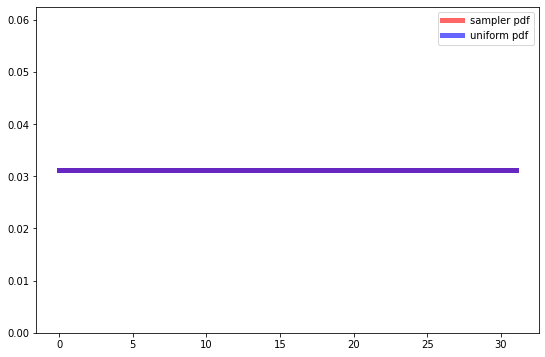

In [78]:
fig, ax = plt.subplots(1, 1)

def uniform(x):
    return 1 / 2**n

s  = Statevector(sampler).data
x  = np.array([i for i in range(2**n)])
y1 = [np.real(np.dot(s[i], s[i].conj())) for i in x]
y2 = [uniform(x) for i in x]

ax.set_ylim([0, 1 / 2**(n-1)])
ax.plot(x, y1, 'r-', lw=5, alpha=0.6, label='sampler pdf')
ax.plot(x, y2, 'b-', lw=5, alpha=0.6, label='uniform pdf')
ax.legend()

r       = 0
samples = [r]
for r_hat in range(1, 32):
    if np.random.rand() < accept(uniform, sampler, r, r_hat):
        samples.append(r_hat)
        r = r_hat

entropy = cross_entropy(uniform, sampler, samples, mode="one")

grad       = one_loss_gradient(uniform, sampler, samples, params)
alpha      = 0.01
mu         = 0.9
new_params = params - alpha * one_gradient_change(mu, grad, 0)
new_params = new_params / np.linalg.norm(new_params)

print(f"Cross entropy of sampler against target: {entropy}.")
print(f"Acceptance ratio of {(len(samples)-1) / 31}.")
print(f"Euclidean norm between initial and udpated params: {np.linalg.norm(params - new_params)}.")

As you can see, we have that the cross entropy is equal to $5$ bits, which is exactly what we should expect with an uniform distribution over $2^{5}$ random variables. (Remember that the cross entropy of two distributions when they are equivalent is equal to that equivalent distribution). Then, all of the possible 32 random variables are accepted, and the difference between the initial parameters and the updated parameters after one learning step is negligible. If that is not enough, the graph also shows us that the target distribution and the distribution given by our QFT sampler are the same. Therefore, we can assure our functions are working correctly!

Getting back on track with the normal distribution we will try to optimize for, to calculate the gradient of the loss function, we are going to be using $32$ samples, i.e., the whole domain of the function. We do this in this case since we have a relatively small domain, so we can take advantage of this and be more precise on our calculations.

In [79]:
samples = [i for i in range(2**n)]

Then we use the samples to calculate the gradient vector of the loss function.

In [80]:
grad = one_loss_gradient(norm, sampler, samples, params)
grad

array([-0.7057458 -0.7057458j ,  0.38034486+0.46345155j,
       -0.07011838-0.10493958j,  0.00510963+0.00955945j])

And finally we update our complex parameter vector as follows.

In [81]:
alpha      = 0.01
mu         = 0.9
new_params = params - alpha * one_gradient_change(mu, grad, 0) # prev_grad is 0 here since its the first change we do
new_params = new_params / np.linalg.norm(new_params)
print(f"New params: {new_params}")
print(f"Difference from old params: {np.linalg.norm(new_params - params)}")

New params: [ 7.07106649e-01+7.07106649e-01j -3.79965553e-04-4.62989365e-04j
  7.00484569e-05+1.04834924e-04j -5.10453460e-06-9.54991255e-06j]
Difference from old params: 0.0006121661650479299


This is one step of the optimization procedure laid out by our algorithm. Before going into a full training, we will also demonstrate what one step of the learning process looks like for a multi-dimensional sampler for the sake of completeness.

**Approximating a three-dimensional distribution**

Now, we are going to run one step of our algorithm trying to approximate a probability distribution depending on three random variables. To do this more fun, the distribution we are going to approximate is that of the sum obtained when rolling three six-sided dice (divided by a normalization constant since we are going to work with $\lceil \log_2(6) \rceil$ qubits). The data for this is taken from [here](https://www.thoughtco.com/probabilities-for-rolling-three-dice-3126558).

In [118]:
def sum_three_dice(x):
    s = x[0] + x[1] + x[2] + 3
    if s == 3 or s == 18:
        return 0.5 / 3404.79
    if s == 4 or s == 17:
        return 1.4 / 3404.79
    if s == 5 or s == 16:
        return 2.8 / 3404.79
    if s == 6 or s == 15:
        return 4.6 / 3404.79
    if s == 7 or s == 14:
        return 7 / 3404.79
    if s == 8 or s == 13:
        return 9.7 / 3404.79
    if s == 9 or s == 12:
        return 11.6 / 3404.79
    if s == 10 or s == 11:
        return 12.5 / 3404.79
    else:
        return 0

In [119]:
r   = list(product([i for i in range(2**int(np.ceil(np.log2(6))))], repeat=3))
r   = [list(r_i) for r_i in r]
tot = 0
for r_i in r:
    tot += sum_three_dice(r_i)
tot

1.0000029370386976

Now, we are going to define our circuit. We are going to use the identity model for the first function, and the linear basis regression model for the second and third ones. 

Sampler 0:


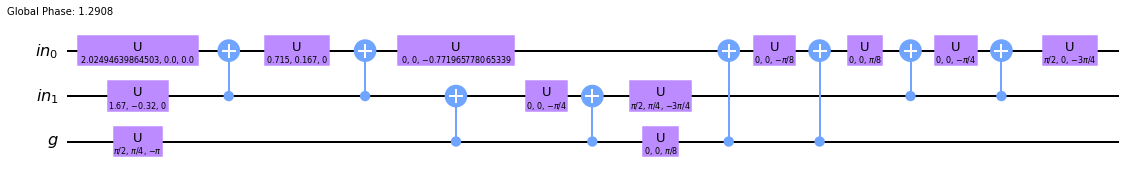

Sampler 1:


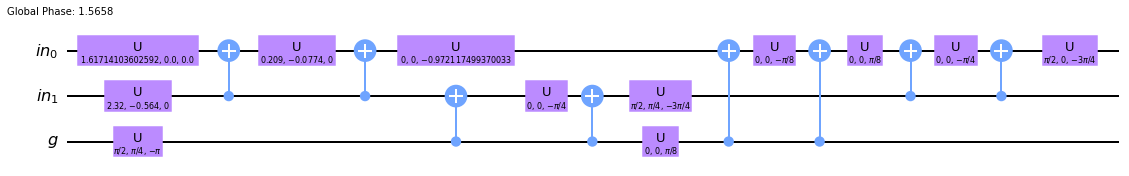

Sampler 2:


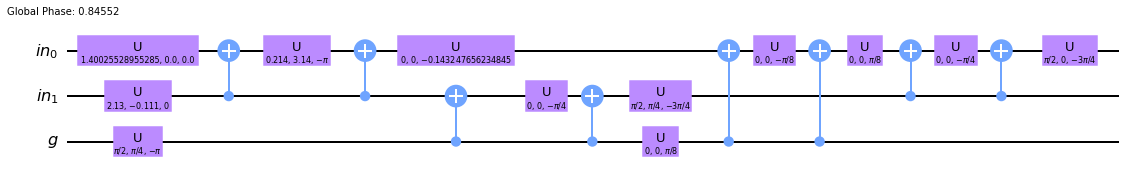

In [121]:
D = 3
n = int(np.ceil(np.log2(6)))
m = 2

params = []
params.append(np.random.random(2 ** m) + np.random.random(2 ** m) * 1j)
params.append([np.random.random(2 ** m) + np.random.random(2 ** m) * 1j for _ in range(2)])
params.append([np.random.random(2 ** m) + np.random.random(2 ** m) * 1j for _ in range(3)])

funcs = [
    lambda var, theta: theta / (np.sqrt(np.dot(theta, theta.conj()))),
    lbrm,
    lbrm,
]

r     = np.random.randint(2**m, size=D) # right now we just take some variable to visualize our circuits
circs = multi_sampler(D, n, m, process_params(r, funcs, params))

for i in range(D):
    print(f"Sampler {i}:")
    display(circs[i].draw())

Now, we are going to generate $32$ random variables that will be used to calculate the gradient.

In [123]:
r        = np.random.randint(2**n, size=D) # set some starting variable
accepted = [r]
counter  = 0
for i in range(31):
    while True:
        r_hat = np.random.randint(2**n, size=D)
        counter += 1
        if np.random.rand() < accept(target, [D, n, m, funcs, params], r, r_hat):
            accepted.append(r_hat)
            r = r_hat
            break
print(f"Total tested: {counter}. Accepted: {len(accepted)-1}.")
print(accepted)

Total tested: 231. Accepted: 31.
[array([5, 7, 2]), array([2, 5, 3]), array([6, 2, 1]), array([6, 1, 6]), array([5, 2, 6]), array([2, 7, 1]), array([5, 2, 3]), array([6, 1, 3]), array([0, 5, 1]), array([3, 5, 1]), array([6, 2, 5]), array([6, 7, 3]), array([1, 3, 1]), array([6, 5, 2]), array([5, 3, 2]), array([3, 5, 3]), array([2, 2, 1]), array([0, 6, 1]), array([3, 1, 3]), array([3, 5, 2]), array([6, 5, 2]), array([6, 1, 3]), array([6, 5, 3]), array([6, 0, 2]), array([3, 6, 4]), array([1, 6, 6]), array([3, 7, 5]), array([6, 6, 3]), array([6, 5, 2]), array([2, 5, 3]), array([2, 3, 5]), array([3, 0, 6])]


Then, this samples are used to calculate the gradient of the loss function.

In [126]:
derivs = [
    id_deriv,
    lbrm_deriv,
    lbrm_deriv,
]

gradient = multi_loss_gradient(sum_three_dice, [D, n, m], accepted, params, funcs, derivs)

Finally, we update the parameters.

In [129]:
alpha      = 0.01
mu         = 0.9
new_params = []
for i in range(len(params)):
    new = params[i] - alpha * one_gradient_change(mu, gradient[i], 0)
    new = new / np.linalg.norm(new)
    new_params.append(new)
print(f"New params:")
for p in new_params:
    print(p)

New params:
[0.10018055-0.01341889j 0.64583839+0.29565226j 0.18492241+0.59485398j
 0.30993442-0.03405003j]
[[-0.00516875+0.5263341j   0.01742401+0.08248883j  0.70147254-0.00851049j
   0.1737877 -0.13347734j]
 [-0.1189461 +0.13944309j  0.13354266-0.0147759j   0.19386286+0.26549892j
   0.10072355-0.07629507j]]
[[ 0.01099235+0.00794628j  0.00111863-0.00696419j  0.00352143+0.0097894j
   0.01662231-0.00536955j]
 [-0.10922084+0.22468559j  0.11830457+0.37424412j  0.49286604+0.13342515j
   0.65852399-0.22748873j]
 [-0.01919837+0.0444897j   0.02336452+0.07119008j  0.09602506+0.02741563j
   0.12978291-0.04453559j]]


And that is one step of the learning algorithm with a distribution depending on a three-dimensional random variable.

**Complete training of one-dimensional normal distribution**

With confidence that everything we've done works correctly, we can go ahead and train a one-dimensional distribution completely. Every 100 steps we are going to save the parameters into a CSV file so we retrieve the paramters at different steps later on if needed.

In [29]:
import csv

In [ ]:
n = 3
m = 2

alpha  = 0.1
mu     = 0.9
change = 0

std    = (2**(n-1)-1) / 6
mean   = (2**(n-1)-1) / 2

def target(x):
    x    = x - (2 ** (n-2))
    frac = 1 / (std * np.sqrt(2 * np.pi))
    exp  = (- 1 / 2) * (((x - mean) / std)**2)
    return frac * np.exp(exp)

params    = np.zeros(2**m, dtype="complex")
params[0] = 1 + 1 * 1j
params    = params / np.linalg.norm(params)

d_steps  = []
d_params = []
filename = 'three_qubit_normal'

for step in range(0, 10000):
    # Create circuit
    sampler = one_sampler(n, m, params)
    
    # Record progress every one hundred learning steps
    if step % 100 == 0:
        d_steps.append(step+1)
        d_params.append(params)
        
        with open('data/'+filename+'.csv', 'w', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(["step", "params"])
            for i in range(len(d_steps)):
                writer.writerow([d_steps[i], d_params[i]])
        
    # Get samples
    samples = [i for i in range(2**n)]
    
    # Compute gradient
    grad = one_loss_gradient(target, sampler, samples, params)

    # Update parameters
    change     = one_gradient_change(mu, grad, change)
    new_params = params - alpha * change
    new_params = new_params / np.linalg.norm(new_params)

    # Check for convergence
    diff = np.linalg.norm(params - new_params)
    if diff == 0:
        break
        
    # If no convergence, update parameters and go on
    params = new_params
    
    # Print output
    clear_output(wait=True)
    print(f"Learning step: {step+1}.")
    print(f"Norm change between old and updated parameters: {diff}.")
        
print(f"Converged in step {step+1} with difference {diff}.")

# Record last step and write final file
d_steps.append(step+1)
d_params.append(params)

with open('data/'+filename+'.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(["step", "params"])
    for i in range(len(d_steps)):
        writer.writerow([d_steps[i], d_params[i]])

In [ ]:
sampler = one_sampler(n, m, params)
entropy = cross_entropy(target, sampler, [i for i in range(2**n)], mode="one")
print(f"Cross entropy of final approximation: {entropy}")

n_entropy = (np.log2(2 * np.pi * (std**2)))/2 + 0.5
print(f"Entropy of normal distribution: {n_entropy}")

In [ ]:
fig, ax = plt.subplots(1, 1)

s  = Statevector(sampler).data
x  = np.array([i for i in range(2**n)])
y1 = [np.real(np.dot(s[i], s[i].conj())) for i in x]
y2 = [target(i) for i in x]

ax.plot(x, y1, 'r-', lw=5, alpha=0.6, label='sampler pdf')
ax.plot(x, y2, 'b-', lw=5, alpha=0.6, label='target pdf')
ax.legend()